In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 加载数据集

#friday = pd.read_csv('/kaggle/input/Friday-WorkingHours-Afternoon-DDos.csv',low_memory = False)

wednesday = pd.read_csv('binary_classification.csv',low_memory = False)
#friday = friday.rename(str.lstrip, axis='columns')
wednesday = wednesday.rename(str.lstrip, axis='columns')
print(wednesday.head())

   Destination_Port  Flow_Duration  Total_Fwd_Packets  Total_Backward_Packets  \
0                80          33643                  3                       5   
1                80       11326939                  5                       0   
2                80        3225962                  4                       0   
3                80         148739                  3                       5   
4                80         700948                  3                       5   

   Total_Length_of_Fwd_Packets  Total_Length_of_Bwd_Packets  \
0                           26                        11601   
1                           30                            0   
2                           24                            0   
3                          363                        11595   
4                           26                        11607   

   Fwd_Packet_Length_Max  Fwd_Packet_Length_Min  Fwd_Packet_Length_Mean  \
0                     20                      0            

In [43]:
# 查看数据集基本信息
wednesday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50960 entries, 0 to 50959
Data columns (total 80 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Destination_Port             50960 non-null  int64  
 1   Flow_Duration                50960 non-null  int64  
 2   Total_Fwd_Packets            50960 non-null  int64  
 3   Total_Backward_Packets       50960 non-null  int64  
 4   Total_Length_of_Fwd_Packets  50960 non-null  int64  
 5   Total_Length_of_Bwd_Packets  50960 non-null  int64  
 6   Fwd_Packet_Length_Max        50960 non-null  int64  
 7   Fwd_Packet_Length_Min        50960 non-null  int64  
 8   Fwd_Packet_Length_Mean       50960 non-null  float64
 9   Fwd_Packet_Length_Std        50960 non-null  float64
 10  Bwd_Packet_Length_Max        50960 non-null  int64  
 11  Bwd_Packet_Length_Min        50960 non-null  int64  
 12  Bwd_Packet_Length_Mean       50960 non-null  float64
 13  Bwd_Packet_Lengt

In [44]:
# 删除有缺失值的行
df = wednesday
# df = df.sample(n = 200000)
# 查看标签情况
print(df['Label'].unique())
print(df.shape)
df = df.dropna()
print(df.shape)

['DDoS' 'DoS Hulk' 'BENIGN' 'PortScan']
(50960, 80)
(50922, 80)


In [45]:
# 定义数据集中的关键特征，如目标端口、传输时间、总发送包数、总接受包数
imp = ['Destination_Port', 'Flow_Duration', 'Total_Fwd_Packets','Total_Backward_Packets']

In [46]:
# for performing feature selection
# 将特征和标签分开
X = df.loc[:,df.columns != "Label"]
# removing first four features considered very important
# 除去四个关键特征
X = X.drop(imp,axis = 1)
y = df.loc[:,df.columns == "Label"]
print(X.shape)

(50922, 75)


C:\Users\yue\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Label
BENIGN      12739
DDoS        12740
DoS Hulk    12703
PortScan    12740
dtype: int64


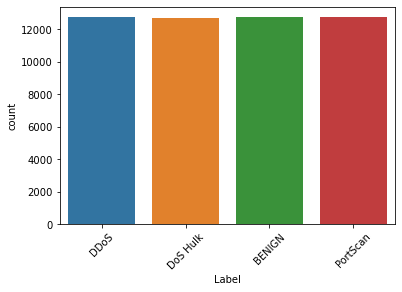

In [47]:
import seaborn as sns
#class distribution <- classifying feature
def ClassDistribution(y):
    ax = sns.countplot(y['Label'],label="Count")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    print(y.groupby('Label').size())

ClassDistribution(y)

In [48]:
# remove columns with more than 75% missing values
# 如果某特征缺失值超过75%，删除该特征（但是前面其实已经处理过空值，这步没什么作用）
def RemoveMissing(train):
    train_missing = (train.isnull().sum() / len(train)).sort_values(ascending = False)
    #train_missing.head()
    train_missing = train_missing.index[train_missing > 0.75]
    all_missing = list(set(train_missing))
    train.drop(all_missing,axis = 1)
    print('There are %d columns with more than 75%% missing values' % len(all_missing))
    return train

X = RemoveMissing(X)

There are 0 columns with more than 75% missing values


In [49]:
# remove columns with only 1 unique value
# 如果某特征只有一个值，删除该特征
def remove_single_unique_values(dataframe):
    cols_to_drop = dataframe.nunique()
    cols_to_drop = cols_to_drop.loc[cols_to_drop.values==1].index
    print('There are %d columns with only 1 unique value' % len(cols_to_drop))
    dataframe = dataframe.drop(cols_to_drop,axis=1)
    return dataframe

X = remove_single_unique_values(X)

There are 10 columns with only 1 unique value


In [50]:
print(X.shape)

(50922, 65)


<AxesSubplot:>

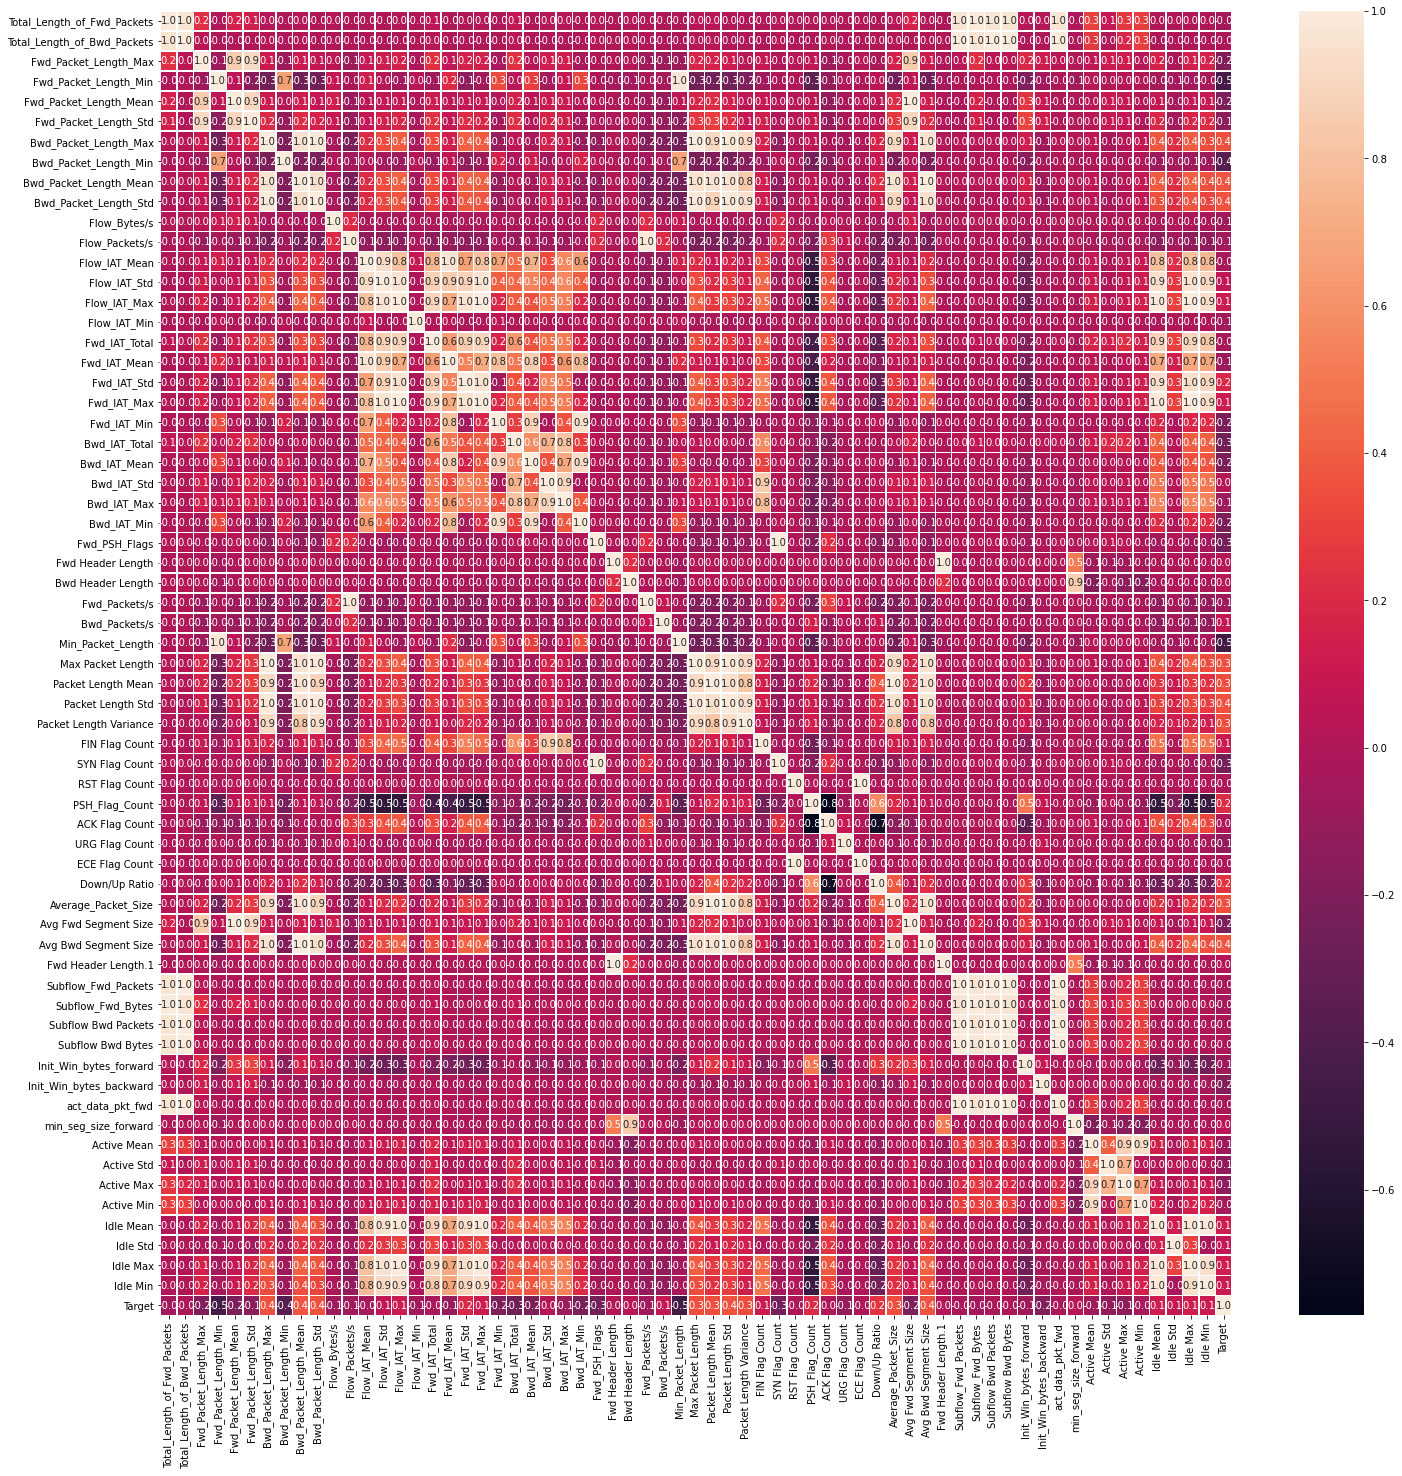

In [51]:
#heatmap
f,ax = plt.subplots(figsize=(24, 24))
corr = X.corr()
sns.heatmap(corr, annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [52]:
#对于相关性较高（大于0.7）的特征，这里也采用直接删除的方式，只保留前面的一个
columns = np.full((corr.shape[0],), True, dtype=bool)
to_drop = []
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.7:
            if columns[j]:
                columns[j] = False
                to_drop.append((corr.columns)[j])
print('删除高度相关的特征：', to_drop)
X = X.drop(to_drop,axis = 1)
print(X.shape)

删除高度相关的特征： ['Total_Length_of_Bwd_Packets', 'Subflow_Fwd_Packets', 'Subflow_Fwd_Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'act_data_pkt_fwd', 'Fwd_Packet_Length_Mean', 'Fwd_Packet_Length_Std', 'Avg Fwd Segment Size', 'Min_Packet_Length', 'Bwd_Packet_Length_Mean', 'Bwd_Packet_Length_Std', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'Average_Packet_Size', 'Avg Bwd Segment Size', 'Fwd_Packets/s', 'Flow_IAT_Std', 'Flow_IAT_Max', 'Fwd_IAT_Total', 'Fwd_IAT_Mean', 'Fwd_IAT_Max', 'Bwd_IAT_Mean', 'Idle Mean', 'Idle Max', 'Idle Min', 'Fwd_IAT_Std', 'Fwd_IAT_Min', 'Bwd_IAT_Min', 'Bwd_IAT_Std', 'Bwd_IAT_Max', 'FIN Flag Count', 'SYN Flag Count', 'Fwd Header Length.1', 'min_seg_size_forward', 'ECE Flag Count', 'Active Max', 'Active Min']
(50922, 25)


In [53]:
print(X.head())

   Total_Length_of_Fwd_Packets  Fwd_Packet_Length_Max  Fwd_Packet_Length_Min  \
0                           26                     20                      0   
1                           30                      6                      6   
2                           24                      6                      6   
3                          363                    363                      0   
4                           26                     20                      0   

   Bwd_Packet_Length_Max  Bwd_Packet_Length_Min   Flow_Bytes/s  \
0                   5840                      0  345599.381700   
1                      0                      0       2.648553   
2                      0                      0       7.439641   
3                   5792                      0   80395.861210   
4                   8760                      0   16596.095570   

   Flow_Packets/s  Flow_IAT_Mean  Flow_IAT_Min  Bwd_IAT_Total  ...  \
0      237.790922   4.806143e+03             4      

In [54]:
#把最开始放一边的四个重要特征加回去
# add back the important features removed earlier
for i in imp:
    X[i] = df[i]

print(X.shape)
print(X.columns)

(50922, 29)
Index(['Total_Length_of_Fwd_Packets', 'Fwd_Packet_Length_Max',
       'Fwd_Packet_Length_Min', 'Bwd_Packet_Length_Max',
       'Bwd_Packet_Length_Min', 'Flow_Bytes/s', 'Flow_Packets/s',
       'Flow_IAT_Mean', 'Flow_IAT_Min', 'Bwd_IAT_Total', 'Fwd_PSH_Flags',
       'Fwd Header Length', 'Bwd Header Length', 'Bwd_Packets/s',
       'RST Flag Count', 'PSH_Flag_Count', 'ACK Flag Count', 'URG Flag Count',
       'Down/Up Ratio', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward',
       'Active Mean', 'Active Std', 'Idle Std', 'Target', 'Destination_Port',
       'Flow_Duration', 'Total_Fwd_Packets', 'Total_Backward_Packets'],
      dtype='object')


In [55]:
# 数据类型处理
X["Flow_Bytes/s"] = X['Flow_Bytes/s'].astype("float64")
X["Flow_Packets/s"] = X['Flow_Packets/s'].astype("float64")

In [56]:
y = df.loc[:,df.columns == "Label"]
y.replace(to_replace='BENIGN', value=0,inplace=True)
y.replace(to_replace=['DDoS','DoS Hulk','PortScan'], value=[1,2,3], inplace=True)

C:\Users\yue\Anaconda\lib\site-packages\pandas\core\frame.py:4524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [57]:
X = X.drop(['Flow_Bytes/s', 'Flow_Packets/s'],axis = 1)

In [58]:
X.columns

Index(['Total_Length_of_Fwd_Packets', 'Fwd_Packet_Length_Max',
       'Fwd_Packet_Length_Min', 'Bwd_Packet_Length_Max',
       'Bwd_Packet_Length_Min', 'Flow_IAT_Mean', 'Flow_IAT_Min',
       'Bwd_IAT_Total', 'Fwd_PSH_Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Bwd_Packets/s', 'RST Flag Count',
       'PSH_Flag_Count', 'ACK Flag Count', 'URG Flag Count', 'Down/Up Ratio',
       'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'Active Mean',
       'Active Std', 'Idle Std', 'Target', 'Destination_Port', 'Flow_Duration',
       'Total_Fwd_Packets', 'Total_Backward_Packets'],
      dtype='object')

In [59]:
X1 = X
X1.head(5)

,Total_Length_of_Fwd_Packets,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Bwd_Packet_Length_Max,Bwd_Packet_Length_Min,Flow_IAT_Mean,Flow_IAT_Min,Bwd_IAT_Total,Fwd_PSH_Flags,Fwd Header Length,...,Init_Win_bytes_forward,Init_Win_bytes_backward,Active Mean,Active Std,Idle Std,Target,Destination_Port,Flow_Duration,Total_Fwd_Packets,Total_Backward_Packets
0,26,20,0,5840,0,4.806143e+03,4,33488,0,72,...,8192,229,0.0,0.0,0.0,1,80,33643,3,5
1,30,6,6,0,0,2.831735e+06,2,0,0,100,...,256,-1,3970.0,0.0,0.0,1,80,11326939,5,0
2,24,6,6,0,0,1.075321e+06,991,0,0,80,...,256,-1,0.0,0.0,0.0,1,80,3225962,4,0
3,363,363,0,5792,0,2.124843e+04,26,148696,0,104,...,29200,235,0.0,0.0,0.0,1,80,148739,3,5
4,26,20,0,8760,0,1.001354e+05,2,700897,0,72,...,8192,229,0.0,0.0,0.0,1,80,700948,3,5


In [63]:
X1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50922 entries, 0 to 50959
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Total_Length_of_Fwd_Packets  50922 non-null  int64  
 1   Fwd_Packet_Length_Max        50922 non-null  int64  
 2   Fwd_Packet_Length_Min        50922 non-null  int64  
 3   Bwd_Packet_Length_Max        50922 non-null  int64  
 4   Bwd_Packet_Length_Min        50922 non-null  int64  
 5   Flow_IAT_Mean                50922 non-null  float64
 6   Flow_IAT_Min                 50922 non-null  int64  
 7   Bwd_IAT_Total                50922 non-null  int64  
 8   Fwd_PSH_Flags                50922 non-null  int64  
 9   Fwd Header Length            50922 non-null  int64  
 10  Bwd Header Length            50922 non-null  int64  
 11  Bwd_Packets/s                50922 non-null  float64
 12  RST Flag Count               50922 non-null  int64  
 13  PSH_Flag_Count  

In [60]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
# encoding and scaling stuff.
categorical = []
for x in X.columns:
    if X[x].dtype == 'object':
        categorical.append(x)
# encoding and scaling

encoder = LabelEncoder()
for a in categorical:
    X[a] = encoder.fit_transform(X[a])

# feature scaling
scaler = RobustScaler()
X = scaler.fit_transform(X)
y = encoder.fit_transform(y.values)

C:\Users\yue\Anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy is:  0.9999345421221444


<AxesSubplot:>

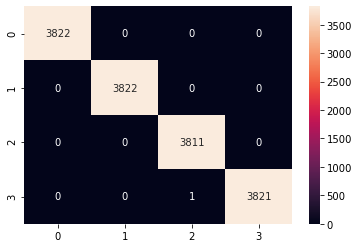

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=True, random_state=123, stratify=y)

#random forest classifier with n_estimators=10 (default)
clf_rf = RandomForestClassifier(n_estimators = 10, random_state=43)      
clr_rf = clf_rf.fit(x_train,y_train)

ac = accuracy_score(y_test,clf_rf.predict(x_test))
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test,clf_rf.predict(x_test))
sns.heatmap(cm,annot=True,fmt="d")

In [62]:
len(x_test)

15277

多模型比较

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, classification_report

In [74]:
logreg_clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial',n_jobs = 3)

rf_clf = RandomForestClassifier(n_estimators=10, random_state = 43)

#does not support multilabel
#pca_clf = PCA(n_components='mle')

ann_clf = MLPClassifier(hidden_layer_sizes=(13,7),activation = 'logistic')

lda_clf = LinearDiscriminantAnalysis(solver='svd')

#knn_clf = KNeighborsClassifier(n_neighbors=3)

nb_clf = GaussianNB()

dtree_clf = DecisionTreeClassifier()

models = {"logreg": logreg_clf,
            "rf": rf_clf,
            "Neural-Network": ann_clf,
            "LDA" : lda_clf,
#            "KNN" : knn_clf,
            "Naive-Bayes" : nb_clf,
            "Decision-Tree" : dtree_clf}

In [75]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
Scores = []
def Utility():
    for x in models:
        print(x)
        score = (cross_val_score(models[x], x_train, y_train, cv=5))
        Scores.append(score)
        print(score)
        

Utility()

logreg
[0.37087951 0.38406509 0.38827325 0.27872072 0.3784542 ]
rf
[0.99971946 0.99957918 0.99985973 1.         0.99985973]
Neural-Network
[0.9904615  0.93996353 0.99158367 0.9511853  0.98148408]
LDA
[0.88848366 0.87936597 0.89367373 0.88666012 0.88904475]
Naive-Bayes
[0.34001964 0.34520971 0.34759433 0.3432459  0.33903773]
Decision-Tree
[0.99957918 0.99943891 0.99971946 0.99985973 0.99971946]


In [76]:
for x in Scores:
    print(np.mean(x))

0.3600785523916398
0.9998036190209005
0.9709356150932809
0.8874456445504277
0.343021461635573
0.9996633468929724


logreg
              precision    recall  f1-score   support

           0       0.32      0.66      0.43      3826
           1       0.41      0.26      0.32      3900
           2       0.48      0.54      0.51      3794
           3       0.06      0.01      0.02      3757

    accuracy                           0.37     15277
   macro avg       0.32      0.37      0.32     15277
weighted avg       0.32      0.37      0.32     15277

[[2539  396  473  418]
 [1111 1029 1698   62]
 [ 530 1080 2050  134]
 [3686   17   15   39]]
rf
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3826
           1       1.00      1.00      1.00      3900
           2       1.00      1.00      1.00      3794
           3       1.00      1.00      1.00      3757

    accuracy                           1.00     15277
   macro avg       1.00      1.00      1.00     15277
weighted avg       1.00      1.00      1.00     15277

[[3826    0    0    0]
 [  

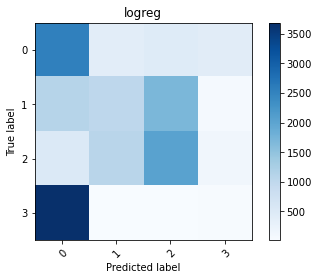

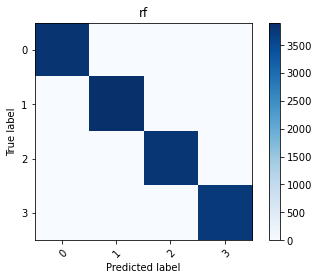

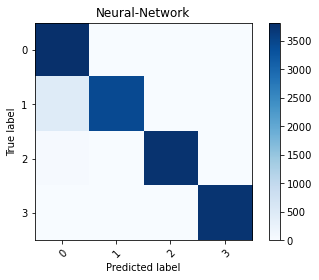

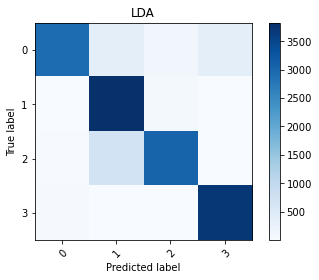

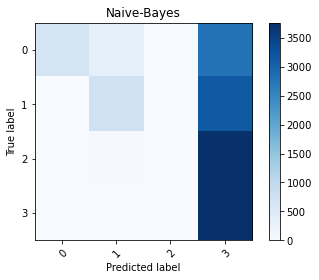

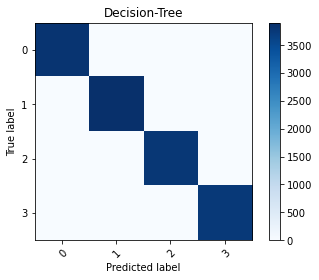

In [82]:
#For two classes
#prints classificationreport , ROC, PR, and CM
def plot_confusion_matrix(y_true, y_pred,normalize=True,title=None,cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    classes = np.unique(y_test)
    np.append(classes,np.unique(y_pred))
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    labels = classes
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=labels, yticklabels=labels,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    return ax

#fig, axes = plt.subplots(1, 2, figsize=(14, 6))
#y_pred = []

for name,model in models.items() :
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    #y_prob = model.predict_proba(x_test)[:, 1:]
    print(name)
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(y_test,y_pred, title = name)
    
    #precision, recall,_ = precision_recall_curve(y_test, y_prob)
    #model_auc_score = roc_auc_score(y_test, y_prob)
    #fpr, tpr, _ = roc_curve(y_test, y_prob)
    #axes[0].plot(fpr, tpr, label= f"{name}, auc = {model_auc_score:.3f}")
    #axes[1].plot(recall, precision, label= f"{name}")
"""
axes[0].legend(loc="lower right")
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].set_title("ROC curve")
axes[1].legend()
axes[1].set_xlabel("recall")
axes[1].set_ylabel("precision")
axes[1].set_title("PR curve")
plt.tight_layout()
plt.show()
"""
plt.show()